In [1]:
from CartPole import CartPole, _remap_angle, remap_angle, _loss, loss
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
import matplotlib.tri as tri
from scipy.optimize import minimize

In [3]:
## main function declerations

# function to do piece-wise addition of two lists
def add_lists(lst1, lst2):
    return [lst1[i]+lst2[i] for i in range(len(lst1))]

# function to generate X, Y datapoints, with Y having random noise added
def make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean, noise_std):

    # initialise instance of CartPole
    pendulum = CartPole()

    # create empty list into which (X,Y) datapoints will go
    datapoints = []

    # fill with num_datapoints number of (X,Y) datapoints
    for i in range(int(num_datapoints//1)):
            
        # initialise random state
        cart_location = np.random.uniform(-9, 9)
        cart_velocity = np.random.uniform(-10, 10)
        pole_angle = np.random.uniform(-np.pi, np.pi)
        pole_velocity = np.random.uniform(-15, 15)
        action = np.random.uniform(-4, 4)
        X_with_action = np.array([cart_location, cart_velocity, pole_angle, pole_velocity, action]) # X_with_action is of type np.array

        ## update state and run one iteration to get new state and Y
        pendulum.setState(X_with_action[:4])
        pendulum.performAction(X_with_action[4])
        new_state = pendulum.getState() # new_state is of type np.array
        Y = new_state - X_with_action[:4]

        # add scaled noise to Y 
        random_noise_vector = np.random.normal(noise_mean, noise_std, 4)
        random_noise_vector[0] *= 9/np.pi
        random_noise_vector[1] *= 10/np.pi
        random_noise_vector[2] *= 1
        random_noise_vector[3] *= 15/np.pi
        Y += random_noise_vector

        # add X, Y datapoints to array
        datapoints.append((X_with_action, Y))

    return datapoints

# function to generate X, Y datapoints, with X and Y having random noise added. Action also has noise added, but default is no noise
def make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y, noise_mean_action=0, noise_std_action=0):

    # initialise instance of CartPole
    pendulum = CartPole()

    # create empty list into which (X,Y) datapoints will go
    datapoints = []

    # fill with num_datapoints number of (X,Y) datapoints
    for i in range(int(num_datapoints//1)):
            
        # initialise random state
        cart_location = np.random.uniform(-9, 9)
        cart_velocity = np.random.uniform(-10, 10)
        pole_angle = np.random.uniform(-np.pi, np.pi)
        pole_velocity = np.random.uniform(-15, 15)
        action = np.random.uniform(-4, 4)
        X_with_action = np.array([cart_location, cart_velocity, pole_angle, pole_velocity, action]) # X_with_action is of type np.array

        ## update state and run one iteration to get new state and Y
        pendulum.setState(X_with_action[:4])
        pendulum.performAction(X_with_action[4])
        new_state = pendulum.getState() # new_state is of type np.array
        Y = new_state - X_with_action[:4]

        # add scaled noise to X
        random_noise_vector = np.random.normal(noise_mean_X, noise_std_X, 4)
        random_noise_vector[0] *= 9/np.pi
        random_noise_vector[1] *= 10/np.pi
        random_noise_vector[2] *= 1
        random_noise_vector[3] *= 15/np.pi
        X_with_action[:4] += random_noise_vector

        # add scaled noise to action: if noise = 0, then action is unchanged
        random_noise_vector = np.random.normal(noise_mean_action, noise_std_action, 1)
        X_with_action[4] += random_noise_vector

        # add scaled noise to Y 
        random_noise_vector = np.random.normal(noise_mean_Y, noise_std_Y, 4)
        random_noise_vector[0] *= 9/np.pi
        random_noise_vector[1] *= 10/np.pi
        random_noise_vector[2] *= 1
        random_noise_vector[3] *= 15/np.pi
        Y += random_noise_vector

        # add X, Y datapoints to array
        datapoints.append((X_with_action, Y))

    return datapoints

# function to generate the OLS matrix given a list of (X,Y) datapoints. each X has length 5
def find_OLS_matrix_with_Action(list_of_X_Y_tuples):

    # initiate empty X and Y matrices where each row will contain each X, Y datapoint
    X = np.zeros((len(list_of_X_Y_tuples), 5))
    Y = np.zeros((len(list_of_X_Y_tuples), 4))

    # populate X and Y matrices' rows with datapoints
    for i in range(len(list_of_X_Y_tuples)):
        X[i] = list_of_X_Y_tuples[i][0]
        Y[i] = list_of_X_Y_tuples[i][1]
    
    # find OLS matrix so solve the equation: Y=CX
    C = np.linalg.lstsq(X, Y, rcond=None)[0]

    return C

# Kernal function for x, xdot and thetadot     X, X2 and sigma are vectors of length 4; function returns a scalar
# works for X, X2, sigma of length 4 and length 5 (if action is included)
def K(X, X2, sigma):

    exponent = 0

    # iterating over state variables within X, X2
    for j in range(4):

        # for non theta components
        if j != 2:
            exponent += ((X[j] - X2[j])**2) / (2*sigma[j]**2)
        
        # for theta component
        else:
            exponent += (np.sin((X[j]-X2[j]) / 2) ** 2) / (2*sigma[j]**2)
    
    # if action is in X and X2:
    if len(X) == 5 and len(X2) == 5:
        exponent += ((X[4] - X2[4])**2) / (2*sigma[4]**2)
    
    return np.exp((-1) * exponent)

# function to return K_M,N matrix (matrix of dimension MxN) given dimensions M, N and sigma
def get_K_MN_matrix(M, N, sigma, array_of_datapoints):

    # set N actual N irrelevant of what is passed in ##### can i fix this so it isn't needed? might be fine without
    N = len(array_of_datapoints)

    # choose M basis centres from array_of_datapoints
    if len(array_of_datapoints[0][0]) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(array_of_datapoints[0][0]) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MN matrix
    K_MN = np.zeros((M, N))


    # fill K_MN matrix
    for i in range(M):
        for j in range(N):
            K_MN[i, j] = K(array_of_datapoints[j][0], M_basis_centres[i], sigma)
    
    return K_MN

# function to return K_MM matrix
def get_K_MM_matrix(M, sigma):


    # choose M basis centres from array_of_datapoints
    if len(sigma) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(sigma) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MM matrix
    K_MM = np.zeros((M, M))

    # fill K_MM matrix
    for i in range(M):
        for j in range(M):
            K_MM[i, j] = K(M_basis_centres[i], M_basis_centres[j], sigma)

    return K_MM
# function to find alpha vector given K_MM matrix, K_MN matrix lamda, array_of_XY_datapoints and index of state vector
def get_alpha(K_MN, K_MM, lamda, array_of_XY_datapoints, index):

    # get Y vector from array_of_XY_datapoints
    # Y vector is of length N; contains one type of state variable only
    Y = np.zeros(len(array_of_XY_datapoints))
    for i in range(len(array_of_XY_datapoints)):
        Y[i] = array_of_XY_datapoints[i][1][index]

    ## get into form A \alpha = b
    A = np.matmul(K_MN, K_MN.T) + lamda * K_MM
    b = np.matmul(K_MN, Y)

    # solve for alpha; this is the alpha vector of length M corresponding to the state variable at the index=index
    alpha = np.linalg.lstsq(A, b, rcond=None)[0]

    return alpha

# define function to return optimum alpha vectors (train model). Basis vectors are known from sobol sequence
def get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda):

    num_datapoints = len(datapoints)

    # train model to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints)
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

    return alpha_x, alpha_xdot, alpha_theta, alpha_thetadot

# define function to get next state given current state for NONLINEAR
def get_next_state_nonlinear(current_state, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma):    


    # choose M basis centres using Sobol sequence
    M = num_basis_centres
    M_basis_centres = sobol_seq.i4_sobol_generate(4, M) # M_basis_centres is a Mx4 array

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15

    # initilise next step variables
    next_step_x, next_step_xdot, next_step_theta, next_step_thetadot = 0, 0, 0, 0

    # next step is given by the dot product of alpha vector and K(x, x') vector
    for i, alpha in enumerate(alpha_x):
        next_step_x += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    for i, alpha in enumerate(alpha_xdot):
        next_step_xdot += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    for i, alpha in enumerate(alpha_theta):
        next_step_theta += alpha * K(current_state, M_basis_centres[i, :], sigma)

    for i, alpha in enumerate(alpha_thetadot):
        next_step_thetadot += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    # find next state
    next_state_x = current_state[0] + next_step_x
    next_state_xdot = current_state[1] + next_step_xdot
    next_state_theta = current_state[2] + next_step_theta
    next_state_thetadot = current_state[3] + next_step_thetadot

    # return next state
    return [next_state_x, next_state_xdot, next_state_theta, next_state_thetadot]

# following is purely for the nonlinear model
def get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its=0):

    pendulum = CartPole()

    num_datapoints = len(datapoints)

    # train model on datapoints to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints)
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

    # if we want the error of the first Y
    if num_its == 0:

        # initialise lists into which actual steps to plot will go
        actual_steps_x, actual_steps_xdot, actual_steps_theta, actual_steps_thetadot = [], [], [], []

        # make lists of actual steps
        for i in range(len(datapoints)):

            # current Y vector
            Y = datapoints[i][1]

            # populate lists of actual steps
            actual_steps_x.append(Y[0])
            actual_steps_xdot.append(Y[1])
            actual_steps_theta.append(Y[2])
            actual_steps_thetadot.append(Y[3])
        
        # convert into numpy arrays
        actual_steps_x = np.array(actual_steps_x)
        actual_steps_xdot = np.array(actual_steps_xdot)
        actual_steps_theta = np.array(actual_steps_theta)
        actual_steps_thetadot = np.array(actual_steps_thetadot)
        
        # make lists predicted steps
        pred_steps_x = np.matmul(K_NM, alpha_x)
        pred_steps_xdot = np.matmul(K_NM, alpha_xdot)
        pred_steps_theta = np.matmul(K_NM, alpha_theta)
        pred_steps_thetadot = np.matmul(K_NM, alpha_thetadot)

        # calculate mean squared error
        mse_x = np.mean((actual_steps_x - pred_steps_x)**2)
        mse_xdot = np.mean((actual_steps_xdot - pred_steps_xdot)**2)
        mse_theta = np.mean((actual_steps_theta - pred_steps_theta)**2)
        mse_thetadot = np.mean((actual_steps_thetadot - pred_steps_thetadot)**2)

        # return the mean squared error
        return np.array([mse_x, mse_xdot, mse_theta, mse_thetadot])


    # if we want the error of the state after num_its iterations
    else: 

        average_mse = []

        mse_x, mse_xdot, mse_theta, mse_thetadot = 0, 0, 0, 0

        # looking at each initial state in datapoints
        for datapoint in datapoints:
            
            # set the initial state in datapoints
            initial_state = datapoint[0]
            pred_state = initial_state
            actual_state = initial_state
            pendulum.setState(actual_state)

            # num_its iterations of simulation
            for its in range(num_its):

                # update predicted and actual states
                pred_state = get_next_state(pred_state, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
                pendulum.performAction()
                actual_state = pendulum.getState()
            
            mse_x += (actual_state[0] - pred_state[0])**2
            mse_xdot += (actual_state[1] - pred_state[1])**2
            mse_theta += (actual_state[2] - pred_state[2])**2
            mse_thetadot += (actual_state[3] - pred_state[3])**2
            
        average_mse = np.array([mse_x/len(datapoints), mse_xdot/len(datapoints), mse_theta/len(datapoints), mse_thetadot/len(datapoints)])

        return average_mse

# function to get mean squared error between actual and predicted states after num_its iterations. works for both nonlinear and linear models
# model_type is either 'linear' or 'nonlinear'
# datapoints needs to be of the form [[initial_state1, .], [initial_state2, .], ...]
def get_mse_between_actual_and_predicted_states(datapoints, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma, num_its, model_type, noise_var_per_sim):

    pendulum = CartPole()

    # initialise mse variables
    mse_x, mse_xdot, mse_theta, mse_thetadot = 0, 0, 0, 0

    # looking at each initial state in datapoints
    for datapoint in datapoints:
        
        # set the initial state in datapoints
        initial_state = np.array(datapoint[0]) # initial_state is of length 5
        pred_state = initial_state
        actual_state = initial_state
        pendulum.setState(actual_state)

    
        # num_its iterations of simulation
        for its in range(num_its):

            # update predicted states.  # pred_state is of type list
            if model_type == 'linear':
                Y = np.matmul(pred_state, C)
                pred_state = pred_state[:4] + Y
                action = 0 ################################### change this so that it is policy
                pred_state = np.append(pred_state, action)

                # add noise to the sim
                noise_to_add_per_state = np.random.normal(0, noise_var_per_sim, 4)
                noise_to_add_per_state[0] *= 9
                noise_to_add_per_state[1] *= 10
                noise_to_add_per_state[2] *= np.pi
                noise_to_add_per_state[3] *= 15
                noise_to_add_per_state = np.append(noise_to_add_per_state, 0)
                pred_state = add_lists(noise_to_add_per_state, pred_state)

            elif model_type == 'nonlinear':
                pred_state = get_next_state_nonlinear(pred_state, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
                action = 0 ################################### change this so that it is policy
                pred_state = np.append(pred_state, action) 

                # add noise to the sim
                noise_to_add_per_state = np.random.normal(0, noise_var_per_sim, 4)
                noise_to_add_per_state[0] *= 9
                noise_to_add_per_state[1] *= 10
                noise_to_add_per_state[2] *= np.pi
                noise_to_add_per_state[3] *= 15
                noise_to_add_per_state = np.append(noise_to_add_per_state, 0)
                pred_state = add_lists(noise_to_add_per_state, pred_state)

            else:
                print('model_type must be either linear or nonlinear')
                return
            
            # update actual states
            pendulum.performAction()
            actual_state = pendulum.getState()

        mse_x += (actual_state[0] - pred_state[0])**2
        mse_xdot += (actual_state[1] - pred_state[1])**2
        mse_theta += (actual_state[2] - pred_state[2])**2
        mse_thetadot += (actual_state[3] - pred_state[3])**2
            
    average_mse = np.array([mse_x/len(datapoints), mse_xdot/len(datapoints), mse_theta/len(datapoints), mse_thetadot/len(datapoints)])

    return average_mse

# function to find Y given X according to nonlinear model, returning Y as a vector
def find_Y_given_X_according_to_nonlinear_model(X, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma):

    # initiate sobol sequence to determine basis centres
    M_basis_centres = sobol_seq.i4_sobol_generate(5, num_basis_centres)  # M_basis_centres is now a matrix of size num_basis_centres x 5; each row is a basis centre

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # find Y
    Y_x, Y_xdot, Y_theta, Y_thetadot = 0, 0, 0, 0
    for i in range(num_basis_centres):
        Y_x += alpha_x[i] * K(X, M_basis_centres[i, :], sigma)
        Y_xdot += alpha_xdot[i] * K(X, M_basis_centres[i, :], sigma)
        Y_theta += alpha_theta[i] * K(X, M_basis_centres[i, :], sigma)
        Y_thetadot += alpha_thetadot[i] * K(X, M_basis_centres[i, :], sigma)
    
    return [Y_x, Y_xdot, Y_theta, Y_thetadot]



In [4]:
### TASK 3.1

## fit linear and nonlinear model to X and noisy Y
## plot graphs of std of noise in training Y against mse in calculated Y: train a model on a given std of training Y. find the mse this model has (vs the real dynamics) this model has at predicting Y  
    ## repeat above step for linear and nonlinear
    ## also maybe do mse in state after 2nd iteration and compare

## plot state variables over time according to linear and nonlinear model and according to real dynamics
    ## use this to see after how many iterations the model is still accurate -> this can be used to update the policy thing

## plot graphs of, for a given noise variance, number of traning datapoints against average mse for both
## policy: train policy on model that was trained on noisy data. also, when do .getstate() for policy, equivalent to blurry sensors, add some noise.
    ## do predictive model control, so only looking at nonlinear model
    ## optimise policy parameters using the nonlinear model trained on noisy data
    ## do rollout, but add noise to the predicted state

## if time: investigate effect of mean change



[0.03       0.0475468  0.07535659 0.11943215 0.1892872  0.3       ]
noise_std =  0.029999999999999995
noise_std =  0.047546795773833396
noise_std =  0.07535659294528742
noise_std =  0.11943215116604919
noise_std =  0.18928720334405796
noise_std =  0.29999999999999993
[0.03       0.0475468  0.07535659 0.11943215 0.1892872  0.3       ] [17.447941692057988, 17.396450456235595, 17.398378899574883, 17.52561874040658, 17.446915047975065, 17.446085201664626]


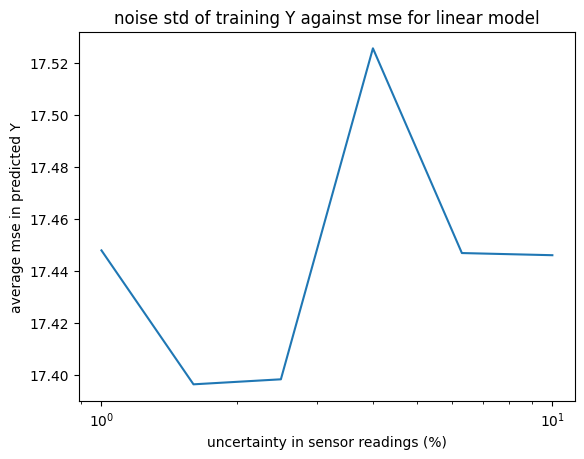

noise_std =  0.029999999999999995


KeyboardInterrupt: 

In [56]:
### TASK 3.1: graphs of std of train Y agaisnt average mse in predicting Y

## linear
def plot_std_of_trainY_against_average_mse_of_prediction_of_linear_with_action(noise_std_to_train):

    pendulum = CartPole()
    
    ## get training datapoints
    num_datapoints_train = 1000
    num_datapoints_test = 10000
    noise_mean_train = 0
    #noise_std_train = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1

    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    list_of_average_mse = []

    for noise_std in noise_std_to_train:

        print('noise_std = ', noise_std)

        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean_train, noise_std)
        C = find_OLS_matrix_with_Action(datapoints_train)


        total_mse = 0

        # test current model on test datapoints
        for datapoint in datapoints_test:
            X = datapoint[0]

            # get actual Y according to model
            pendulum.setState(X[:4])
            pendulum.performAction(X[4])
            new_state = pendulum.getState()
            real_Y = np.array(new_state) - np.array(X[:4])

            # get predicted Y according to model
            pred_Y = X @ C

            # get mse
            mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/num_datapoints_test
        list_of_average_mse.append(average_mse)


    # plot graph of noise_std against average mse
    x_to_plot = (np.logspace(np.log10(1), np.log10(10), len(noise_std_to_train)))
    x_to_plot = [round(x, 1) for x in x_to_plot]
    print(noise_std_to_train, list_of_average_mse)
    plt.plot(x_to_plot, list_of_average_mse)
    #plt.xlabel('training Y noise std relative to std of pole angle')
    plt.xlabel('uncertainty in sensor readings (%)')
    plt.xscale('log')
    plt.ylabel('average mse in predicted Y')
    plt.title('noise std of training Y against mse for linear model')

    plt.show()


## nonlinear
def plot_std_of_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(noise_std_to_train, num_basis_centres, sigma, lamda):

    pendulum = CartPole()
    
    ## get training datapoints
    num_datapoints_train = 500
    num_datapoints_test = 5000
    noise_mean_train = 0
    noise_std_train = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1

    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    list_of_average_mse = []

    for noise_std in noise_std_to_train:

        print('noise_std = ', noise_std)

        # train nonlinear model on noisy data
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean_train, noise_std)
        alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)

        total_mse = 0

        # test current model on test datapoints
        for datapoint in datapoints_test:
            X = datapoint[0]

            # get actual Y according to model
            pendulum.setState(X[:4])
            pendulum.performAction(X[4])
            new_state = pendulum.getState()
            real_Y = np.array(new_state) - np.array(X[:4])

            # get predicted Y according to nonlienar model. Action is included as the last entry of X
            new_state = get_next_state_nonlinear(X, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
            pred_Y = new_state - X[:4]

            # get mse
            mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/num_datapoints_test
        list_of_average_mse.append(average_mse)


    # plot graph of noise_std against average mse
    print(noise_std_to_train, list_of_average_mse)
    x_to_plot = (np.logspace(np.log10(1), np.log10(10), len(noise_std_to_train)))
    x_to_plot = [round(x, 1) for x in x_to_plot]
    plt.plot(x_to_plot, list_of_average_mse)
    #plt.xlabel('training Y noise std relative to std of pole angle')
    plt.xlabel('uncertainty in sensor readings (%)')
    plt.xscale('log')
    plt.ylabel('average mse in predicted Y')
    plt.title('noise std of training Y against mse for nonlinear model')

    plt.show()



Y_stds_to_test = np.logspace(np.log10(0.03), np.log10(0.3), 6)
print(Y_stds_to_test)
plot_std_of_trainY_against_average_mse_of_prediction_of_linear_with_action(Y_stds_to_test)


# set optimal sigma, lamda, num_basis centres
## the following few lines takes a fair few minutes
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
num_basis_centres = 250
plot_std_of_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(Y_stds_to_test, num_basis_centres, sigma, lamda)



noise_mean =  0.00030000000000000014
noise_mean =  0.0007535659294528741
noise_mean =  0.0018928720334405796
noise_mean =  0.004754679577383345
noise_mean =  0.011943215116604919
noise_mean =  0.029999999999999995
[0.0003     0.00075357 0.00189287 0.00475468 0.01194322 0.03      ] [18.260424292358376, 17.819467721715018, 18.005821744036034, 18.122118922217098, 18.01271006102194, 17.964391114151233]


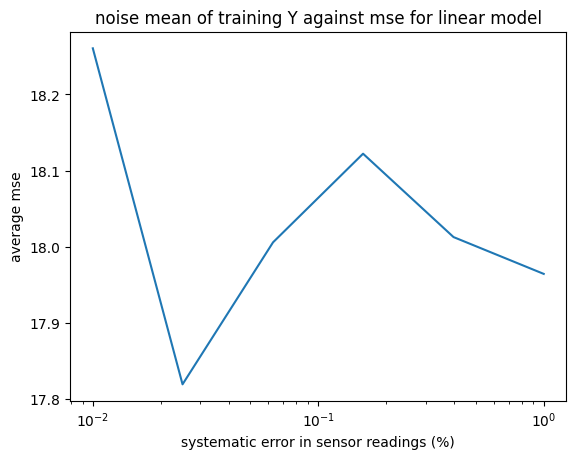

noise_mean =  0.00030000000000000014
noise_mean =  0.0007535659294528741
noise_mean =  0.0018928720334405796
noise_mean =  0.004754679577383345
noise_mean =  0.011943215116604919
noise_mean =  0.029999999999999995
[0.0003     0.00075357 0.00189287 0.00475468 0.01194322 0.03      ] [0.041063758414095944]


ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

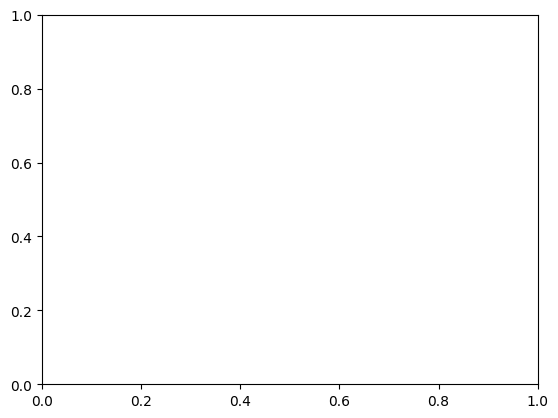

In [75]:
### TASK 3.1: graphs of mean of train Y against average mse in predicting Y for a given noise std of train Y

## linear
def plot_mean_of_trainY_against_average_mse_of_prediction_of_linear_with_action(noise_means_to_train, noise_std_to_train):

    pendulum = CartPole()
    
    ## get training datapoints
    num_datapoints_train = 500
    num_datapoints_test = 10000
    #noise_mean_train = 0
    #noise_std_train = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1

    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    list_of_average_mse = []

    for noise_mean in noise_means_to_train:

        print('noise_mean = ', noise_mean)

        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean, noise_std_to_train)
        C = find_OLS_matrix_with_Action(datapoints_train)

        total_mse = 0

        # test current model on test datapoints
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]


            # # get actual Y according to model
            # pendulum.setState(X[:4])
            # pendulum.performAction(X[4])
            # new_state = pendulum.getState()
            # real_Y = np.array(new_state) - np.array(X[:4])

            # get predicted Y according to model
            pred_Y = X @ C

            # get mse
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/num_datapoints_test
        list_of_average_mse.append(average_mse)


    # plot graph of noise_std against average mse
    print(noise_means_to_train, list_of_average_mse)
    x_to_plot = (np.logspace(np.log10(0.01), np.log10(1), len(noise_means_to_train)))
    x_to_plot = [round(x, 3) for x in x_to_plot]
    plt.plot(x_to_plot, list_of_average_mse)
    plt.xlabel('systematic error in sensor readings (%)')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('noise mean of training Y against mse for linear model')

    plt.show()

### DO NONLINEAR TOO
def plot_mean_of_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(noise_means_to_train, noise_std_to_train, num_basis_centres, sigma, lamda):

    pendulum = CartPole()
    
    ## get training datapoints
    num_datapoints_train = 500
    num_datapoints_test = 3000
    #noise_mean_train = 0
    #noise_std_train = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1

    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    list_of_average_mse = []

    for noise_mean in noise_means_to_train:

        print('noise_mean = ', noise_mean)

        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean, noise_std_to_train)

    #     error_vector = get_error_between_actual_and_predicted(datapoints_train, num_basis_centres, sigma, lamda, num_its=0)
    
    # list_of_average_mse.append(np.average(error_vector))
        
        # test current model on test datapoints
        alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # # get actual Y according to model
            # pendulum.setState(X[:4])
            # pendulum.performAction(X[4])
            # new_state = pendulum.getState()
            # real_Y = np.array(new_state) - np.array(X[:4])

            # get predicted Y according to nonlienar model. Action is included as the last entry of X
            new_state = get_next_state_nonlinear(X, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
            pred_Y = new_state - X[:4]

            # get mse
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/num_datapoints_test
        list_of_average_mse.append(average_mse)


    # plot graph of noise_std against average mse
    print(noise_means_to_train, list_of_average_mse)
    x_to_plot = (np.logspace(np.log10(0.01), np.log10(1), len(noise_means_to_train)))
    x_to_plot = [round(x, 3) for x in x_to_plot]
    plt.plot(x_to_plot, list_of_average_mse)
    plt.xlabel('systematic error in sensor readings (%)')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('noise mean of training Y against mse for nonlinear model')

    plt.show()

noise_std_to_train = 0
noise_means_to_train = np.array([0, 0.1])
noise_means_to_train = np.logspace(np.log10(0.0003), np.log10(0.03), 6)
plot_mean_of_trainY_against_average_mse_of_prediction_of_linear_with_action(noise_means_to_train, noise_std_to_train)

sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
num_basis_centres = 250
plot_mean_of_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(noise_means_to_train, noise_std_to_train, num_basis_centres, sigma, lamda)

num_datapoints =  500
[500] [1.0716454270509617]


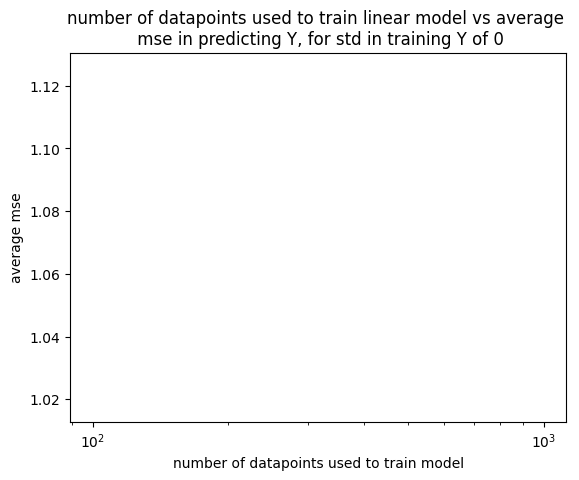

num_datapoints =  500
[500] [1.034685759154135]


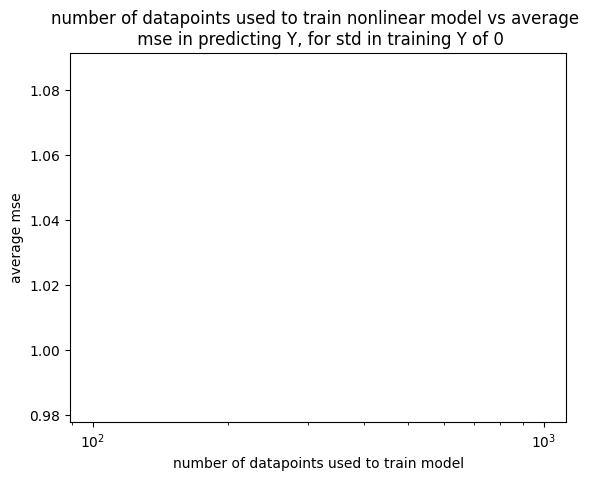

In [81]:
### TASK 3.1: graphs of number of training datapoints against average mse for a given noise std in Y

def plot_num_train_datapoints_against_average_mse_for_given_std_in_Y_linear(num_datapoints_to_test, noise_mean_train, noise_std_train):

    num_datapoints_test = 1000

    # make datapoints to test perfect
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)
    
    list_of_average_mse = []

    for num_datapoints in num_datapoints_to_test:

        print('num_datapoints = ', num_datapoints)

        # create training set with noise and of specificed length
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean_train, noise_std_train)

        # train linear model
        C = find_OLS_matrix_with_Action(datapoints_train)

        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to model
            pred_Y = X @ C

            # get mse
            # mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/(num_datapoints_test*16)
        list_of_average_mse.append(average_mse)
    
    # plot graph of number of datapoints used to train against average mse
    print(num_datapoints_to_test, list_of_average_mse)
    plt.plot(num_datapoints_to_test, list_of_average_mse)
    plt.xlabel('number of datapoints used to train model')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('number of datapoints used to train linear model vs average \n mse in predicting Y, for std in training Y of {}'.format(noise_std_train))

    plt.show()

def plot_num_train_datapoints_against_average_mse_for_given_std_in_Y_nonlinear(num_datapoints_to_test, noise_mean_train, noise_std_train, num_basis_centres, sigma, lamda):


    # noise_mean_train = 0
    # noise_std_train = 0
    num_datapoints_test = 1000

    # make datapoints to test perfect
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)
    
    list_of_average_mse = []

    for num_datapoints in num_datapoints_to_test:

        print('num_datapoints = ', num_datapoints)

        # create training set with noise and of specificed length
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean_train, noise_std_train)

        # train nonlinear model
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean_train, noise_std_train)
        alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)


        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to model
            new_state = get_next_state_nonlinear(X, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
            pred_Y = new_state - X[:4]

            # get mse
            # mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/(num_datapoints_test*25)
        list_of_average_mse.append(average_mse)
    
    # plot graph of number of datapoints used to train against average mse
    print(num_datapoints_to_test, list_of_average_mse)
    plt.plot(num_datapoints_to_test, list_of_average_mse)
    plt.xlabel('number of datapoints used to train model')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('number of datapoints used to train nonlinear model vs average \n mse in predicting Y, for std in training Y of {}'.format(noise_std_train))

    plt.show()
        

num_datapoints_to_test = np.logspace(np.log10(100), np.log10(1000), 6)

noise_mean_train = 0
noise_std_train = 4 * 0.03 # 0.03 == 1%

noise_std_train = 0
num_datapoints_to_test = np.array([500])

plot_num_train_datapoints_against_average_mse_for_given_std_in_Y_linear(num_datapoints_to_test, noise_mean_train, noise_std_train)


num_datapoints_to_test = np.logspace(np.log10(500), np.log10(4000), 6)
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
num_basis_centres = 250

noise_std_train = 0
num_datapoints_to_test = np.array([500])


plot_num_train_datapoints_against_average_mse_for_given_std_in_Y_nonlinear(num_datapoints_to_test, noise_mean_train, noise_std_train, num_basis_centres, sigma, lamda)
    

models fitted


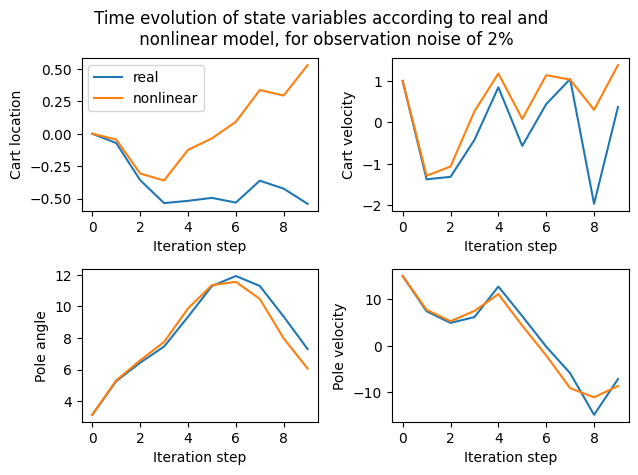

In [7]:
## TASK 3.1: graphs of state variables over time, for linear, nonlinear and real dynamics
## inc

def plot_state_variables_over_time_linear_nonlinear_real_with_observation_noise(initial_state, no_its, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma):

    # Create list of actions to test model's response to actions
    actions = np.random.normal(1, 0.5, no_its)
    actions = np.ones(no_its)

    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    real_state = initial_state
    linear_state = initial_state
    nonlinear_state = initial_state

    # initialise lists for data to plot
    real_xs, real_xdots, real_thetas, real_thetadots = [], [], [], []
    linear_xs, linear_xdots, linear_thetas, linear_thetadots = [], [], [], []
    nonlinear_xs, nonlinear_xdots, nonlinear_thetas, nonlinear_thetadots = [], [], [], []

    # create list for x axis
    iteration_list = list(range(no_its))

    # run no_its simulations
    for it in range(no_its):

        action = actions[it]
        
        # run one real simulation
        pendulum.performAction(action)
        real_state = pendulum.getState()

        # append real state variables to lists to plot
        real_xs.append(real_state[0])
        real_xdots.append(real_state[1])
        real_thetas.append(real_state[2])
        real_thetadots.append(real_state[3])

        # run one linear simulation
        linear_state_with_action = np.append(linear_state, action)
        linear_change = linear_state_with_action @ C
        new_linear_state = linear_state + linear_change
        linear_state = new_linear_state

        # append linear state variables to lists to plot
        linear_xs.append(new_linear_state[0])
        linear_xdots.append(new_linear_state[1])
        linear_thetas.append(new_linear_state[2])
        linear_thetadots.append(new_linear_state[3])

        # run one nonlienar simulation
        nonlinear_state_with_action = np.append(nonlinear_state, action)
        new_nonlinear_state = get_next_state_nonlinear(nonlinear_state_with_action, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
        nonlinear_state = new_nonlinear_state

        # append nonlinear state variables to lists to plot
        nonlinear_xs.append(new_nonlinear_state[0])
        nonlinear_xdots.append(new_nonlinear_state[1])
        nonlinear_thetas.append(new_nonlinear_state[2])
        nonlinear_thetadots.append(new_nonlinear_state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, real_xs, label='real')
    plt.plot(iteration_list, linear_xs, label='linear')
    plt.plot(iteration_list, nonlinear_xs, label='nonlinear')
    plt.xlabel('iteration')
    plt.ylabel('$x$')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, real_xdots, label='real')
    plt.plot(iteration_list, linear_xdots, label='linear')
    plt.plot(iteration_list, nonlinear_xdots, label='nonlinear')
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, real_thetas, label='real')
    plt.plot(iteration_list, linear_thetas, label='linear')
    plt.plot(iteration_list, nonlinear_thetas, label='nonlinear')
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, real_thetadots, label='real')
    plt.plot(iteration_list, linear_thetadots, label='linear')
    plt.plot(iteration_list, nonlinear_thetadots, label='nonlinear')
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('Time evolution of state variables according to real, linear and nonlinear models')
    plt.tight_layout()
    plt.show()



def plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_steps, num_basis_centres, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions=None):

    # initialsie instance of cartpole
    pendulum = CartPole()

    # initialise list of iteration steps
    iteration_steps = list(range(no_steps))

    # initialise empty list into which real states, predicted states will go
    pred_cart_locations = [initial_state[0]]
    pred_cart_velocities = [initial_state[1]]
    pred_pole_angles = [initial_state[2]]
    pred_pole_velocities = [initial_state[3]]
    real_cart_locations = [initial_state[0]]
    real_cart_velocities = [initial_state[1]]
    real_pole_angles = [initial_state[2]]
    real_pole_velocities = [initial_state[3]]

    linear_cart_locations = [initial_state[0]]
    linear_cart_velocities = [initial_state[1]]
    linear_pole_angles = [initial_state[2]]
    linear_pole_velocities = [initial_state[3]]

    actual_state = initial_state
    pred_state = initial_state
    linear_state = initial_state

    # if no actions inputted, same as saying they are all 0
    if list_of_actions is None:
        list_of_actions = np.zeros(no_steps)

    # loop over iteration steps
    for it in iteration_steps:

        # looking for the next state
        it += 1
        if it >= no_steps:
            break
  
        # get next actual state
        pendulum.setState(actual_state[:4])
        pendulum.performAction(actual_state[4])
        next_actual_state = pendulum.getState()
        next_actual_state = np.append(next_actual_state, list_of_actions[it])


        # get next predicted state
        # pred_state has dimension 5, C has dimension 5x5
        pred_change_in_state = find_Y_given_X_according_to_nonlinear_model(pred_state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        next_pred_state = add_lists(pred_state[:4], pred_change_in_state)
        next_pred_state.append(list_of_actions[it])

        # get next linear state
        linear_state_with_action = np.append(linear_state[:4], list_of_actions[it])
        linear_change_in_state = linear_state_with_action @ C # linear_change_in_state has dimension 4
        next_linear_state = linear_state[:4] + linear_change_in_state

        # append states to lists
        pred_cart_locations.append(next_pred_state[0])
        pred_cart_velocities.append(next_pred_state[1])
        pred_pole_angles.append(next_pred_state[2])
        pred_pole_velocities.append(next_pred_state[3])
        real_cart_locations.append(next_actual_state[0])
        real_cart_velocities.append(next_actual_state[1])
        real_pole_angles.append(next_actual_state[2])
        real_pole_velocities.append(next_actual_state[3])
        linear_cart_locations.append(next_linear_state[0])
        linear_cart_velocities.append(next_linear_state[1])
        linear_pole_angles.append(next_linear_state[2])
        linear_pole_velocities.append(next_linear_state[3])
        
        # update current state ready for next iteration
        actual_state = next_actual_state
        pred_state = next_pred_state
        linear_state = next_linear_state
    
    # plot the rollouts
    plt.subplot(2, 2, 1)
    plt.plot(iteration_steps, real_cart_locations, label='real')
    plt.plot(iteration_steps, pred_cart_locations, label='nonlinear')
    #plt.plot(iteration_steps, linear_cart_locations, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart location')
    plt.title('\n')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iteration_steps, real_cart_velocities, label='real')
    plt.plot(iteration_steps, pred_cart_velocities, label='nonlinear')
    #plt.plot(iteration_steps, linear_cart_velocities, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart velocity')
    plt.title('\n')
    #plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(iteration_steps, real_pole_angles, label='real')
    plt.plot(iteration_steps, pred_pole_angles, label='nonlinear')
    #plt.plot(iteration_steps, linear_pole_angles, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole angle')
   
    #plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(iteration_steps, real_pole_velocities, label='real')
    plt.plot(iteration_steps, pred_pole_velocities, label='nonlinear')
    #plt.plot(iteration_steps, linear_pole_velocities, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole velocity')
  
    #plt.legend()

    #plt.subplots_adjust(top=10)
    #plt.set_size_inches(1, 1)
    plt.tight_layout()
    plt.suptitle('Time evolution of state variables according to real and \n nonlinear model, for observation noise of 2%') # add in if oscillations or rotations
    plt.show()



## create noisy dataset
##### SET THE NUMBER OF DATAPOINTS AND NOISE STD TO APPROPRIATE VALUES #####
datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints=2000, noise_mean=0, noise_std=0.03*1)

# train linear model
C = find_OLS_matrix_with_Action(datapoints_train)

print("models fitted")

# train nonlinear model
num_basis_centres = 250
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)


initial_state = np.array([-1, 1, np.pi, 15]) # rotations
initial_state = np.array([0, 0, np.pi, 0])
no_its = 10
#plot_state_variables_over_time_linear_nonlinear_real_with_observation_noise(initial_state, no_its, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)

initial_state = np.array([0, 1, np.pi, 15, 0])
list_of_actions = np.ones(no_its)
list_of_actions = np.array([5, 1, 3, -3, 2, 4, 2, -5, 0, 0])
plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_its, num_basis_centres, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions)


In [83]:
## train nonlinear model, to best of our ability with noise

num_datapoints = 2000 ###### SET BASED ON REASONABLE NUMBER FOUND IN PREVIOUS PART
num_basis_centres = 250
lamda = 10 **(-3)
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
noise_std_for_nonlinear_model_for_model_predictive_policy = 0.15 #######
datapoints = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean=0, noise_std=noise_std_for_nonlinear_model_for_model_predictive_policy)
alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda) # used within opt. functions

In [84]:
## TASK 3.1: OPTIMISE POLICY USING MODEL PREDICTIVE CONTROL


# define function to return total loss using non-linear model. in form for use with scipy
def total_loss_according_to_non_linear_model(p):
    
    state = [0, 0, 0.1, 0]  # initial state
    no_its = 5 # chosen as nonlinear model is mostly accurate up to this point

    # get loss of first iteration
    pendulum = CartPole()
    pendulum.setState(state)
    loss_value = pendulum.loss()

    # running model simulation and calculating total loss
    for it in range(no_its-1): # no_its-1 becuase first iteration already done

        # get action = policy
        action = np.dot(p, state)
        
        # run one iteration of model simulation to get next state
        state_with_action = list(state)
        state_with_action.append(action)
        Y = find_Y_given_X_according_to_nonlinear_model(state_with_action, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        new_state = np.array(Y) + np.array(state)

        # get and add loss
        pendulum.setState(new_state)
        loss_value += pendulum.loss()

        # set variable state for next iteration
        state = new_state
    
    return loss_value

# trying a variery of initial guesses
def get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses):

    # try a good variety of initial guesses
    array_of_initial_guesses = sobol_seq.i4_sobol_generate(4, num_initial_guesses-1) # had dimensions num_initial_guesses x 4
    array_of_initial_guesses = np.append(array_of_initial_guesses, np.array([[0.357, 0.967, 15.9, 2.39]]), axis=0) # # use optimum found in previous part as the initial guesses

    # shift sequences so that they are scaled and centre 0
    array_of_initial_guesses *= 14
    array_of_initial_guesses -= 14/2

    # initialise list of trials of optimal p
    list_of_potential_ps_and_values = []
    list_of_potential_ps = []
    list_of_potential_values = []

    for initial_guess in array_of_initial_guesses:

        result = minimize(total_loss_according_to_non_linear_model, initial_guess, method='Nelder-Mead', tol=0.01)
        # print("done one of the initial guesses")
        maybe_optimal_p = result.x
        value_at_this_p = result.fun

        # print("before passing through opt alg", initial_guess, total_loss_according_to_non_linear_model(initial_guess))
        # print("after passing through optimizatin alg", maybe_optimal_p, value_at_this_p)

        list_of_potential_ps.append(maybe_optimal_p)
        list_of_potential_values.append(value_at_this_p)
        

        list_of_potential_ps_and_values.append((maybe_optimal_p, value_at_this_p))
    
    # get p that corresponds to minimum value of the function
    min_index = list_of_potential_values.index(min(list_of_potential_values))

    ### REMOVE THIS CODE
    # list_of_potential_values.pop(min_index)
    # list_of_potential_ps.pop(min_index)
    # list_of_potential_values.pop(min_index)
    # list_of_potential_ps.pop(min_index)

    min_index = list_of_potential_values.index(min(list_of_potential_values))
    optimal_p = list_of_potential_ps[min_index]

    return optimal_p, min_index


## set parameters of nonlinear model in optimizing function for scipy
optimal_p_noisy_Y_model_predictive_control, min_index = get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses=5)

print(optimal_p_noisy_Y_model_predictive_control, "min index is", min_index)

#optimal_p_noisy_Y_model_predictive_control = [ 0.35722768,  0.96705494, 15.88002628,  2.39390662]


[-9.50563991 -5.03919508 13.94863724  0.69017546] min index is 1


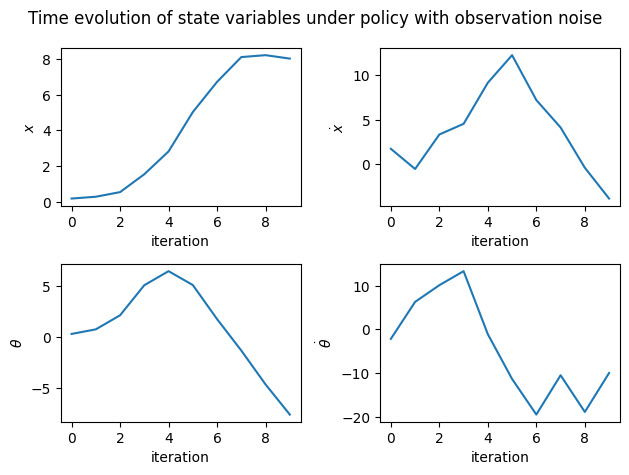

In [87]:
# function to plot time evolution of variables under policy
def plot_time_evolution_of_state_variables_using_real_dynamics_under_policy_with_observation_noise(initial_state, optimal_p_noisy_Y_model_predictive_control, no_its, noise_std):

    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    state = initial_state

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [], [], [], []

    # create list for x axis
    iteration_list = list(range(no_its))

    # run no_its simulations
    for it in range(no_its):
        
        # run one simulation, adding noise to observed dynamics for control
        current_state = pendulum.getState()
        oberservation_noise = np.random.normal(0, noise_std, 4)
        policy = np.dot(optimal_p_noisy_Y_model_predictive_control, current_state + oberservation_noise)
        pendulum.performAction(policy)
        state = pendulum.getState()

        # append state variables to lists to plot
        xs.append(state[0])
        xdots.append(state[1])
        thetas.append(state[2])
        thetadots.append(state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('Time evolution of state variables under policy with observation noise')
    plt.tight_layout()
    plt.show()




initial_state = np.array([0, 0, 0.5, 0])
no_its = 10
rollout_observation_noise_std = 0.06 ### 
# 0.0: 0.7   0.03: 0.6   0.06: 0.6 but less stable     0.09: 0.6 but even less

# 


plot_time_evolution_of_state_variables_using_real_dynamics_under_policy_with_observation_noise(initial_state, optimal_p_noisy_Y_model_predictive_control, no_its, rollout_observation_noise_std)

0
1
2
3
4
5
6
7
8


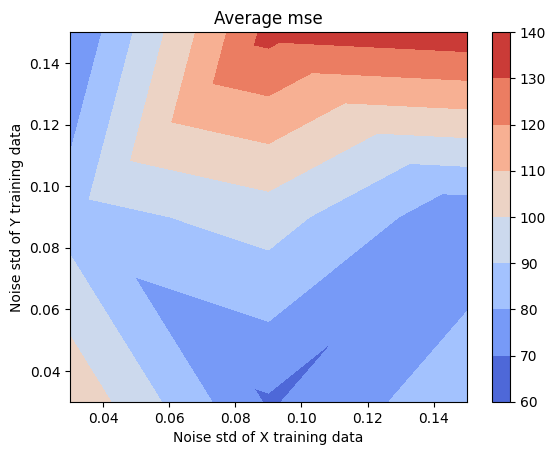

In [101]:
### TASK 3.2

## train model on noisy x and noisy y
## plot contour plots of std of noise in training X and Y against mse in calculated Y
## plot graphs of, for a given noise variance (in X and Y), number of traning datapoints against average mse for both
## policy: train policy on model that was trained on noisy data. also, for each iteration of rollout, do .getstate, current_state += noise, .setstate. This mimics shaking the table

## if time: investigate errors in action


def plot_std_of_trainX_and_trainY_against_average_mse_of_prediction_of_linear_with_action(noise_std_to_train_X, noise_std_to_train_Y):

    
    ## get training datapoints
    num_datapoints_train = 800
    num_datapoints_test = 5000
    noise_mean_train = 0

    # make noise-free test datapoints
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    x_grid, y_grid = np.meshgrid(noise_std_to_train_X, noise_std_to_train_Y)

    # Compute the z values by iterating over all combinations of x and y for contour plot
    z = []
    for i, (xi, yi) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):

        print(i)

        # train linear model on noisy X and Y
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints_train, noise_mean_X=0, noise_std_X=xi, noise_mean_Y=0, noise_std_Y=yi)
        C = find_OLS_matrix_with_Action(datapoints_train)

        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to model
            pred_Y = X @ C

            # get mse
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            #mse /= 16
            total_mse += mse
        
        # append the mse for this current linear model to z
        average_mse = total_mse/(num_datapoints_test*16)
        z.append(average_mse)

    ## create contour plot
    z = np.array(z)
    triangulation = tri.Triangulation(x_grid.flatten(), y_grid.flatten())

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the tricontourf plot
    contour = ax.tricontourf(triangulation, z, cmap='coolwarm')

    # Add a colorbar
    cbar = plt.colorbar(contour)

    # Set axis labels and title
    ax.set_xlabel('Noise std of X training data')
    ax.set_ylabel('Noise std of Y training data')
    ax.set_title('Average mse')

    # Show the plot
    plt.show()

def plot_std_of_trainX_and_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(noise_std_to_train_X, noise_std_to_train_Y, num_basis_centres, sigma, lamda):


    ## get training datapoints
    num_datapoints_train = 500
    num_datapoints_test = 1000
    noise_mean_train = 0

    # make noise-free test datapoints
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)

    x_grid, y_grid = np.meshgrid(noise_std_to_train_X, noise_std_to_train_Y)

    # Compute the z values by iterating over all combinations of x and y for contour plot
    z = []
    for i, (xi, yi) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):

        print(i)

        # train nonlinear model on noisy X and Y
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints_train, noise_mean_X=0, noise_std_X=xi, noise_mean_Y=0, noise_std_Y=yi)
        alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)

        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to nonlienar model. Action is included as the last entry of X
            new_state = get_next_state_nonlinear(X, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
            pred_Y = new_state - X[:4]

            # get mse
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        # append the mse for this current linear model to z
        average_mse = total_mse/num_datapoints_test
        z.append(average_mse)

    ## create contour plot
    z = np.array(z)
    triangulation = tri.Triangulation(x_grid.flatten(), y_grid.flatten())

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the tricontourf plot
    contour = ax.tricontourf(triangulation, z, cmap='coolwarm')

    # Add a colorbar
    cbar = plt.colorbar(contour)

    # Set axis labels and title
    ax.set_xlabel('Noise std of X training data')
    ax.set_ylabel('Noise std of Y training data')
    ax.set_title('Average mse')

    # Show the plot
    plt.show()
    

# , 0.07, 0.09, 0.12, 0.15, 0.18
noise_std_to_train_X = np.array([0.03, 0.09, 0.15])
noise_std_to_train_Y = np.array([0.03, 0.09, 0.15])
#plot_std_of_trainX_and_trainY_against_average_mse_of_prediction_of_linear_with_action(noise_std_to_train_X, noise_std_to_train_Y)
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
num_basis_centres = 250
plot_std_of_trainX_and_trainY_against_average_mse_of_prediction_of_nonlinear_with_action(noise_std_to_train_X, noise_std_to_train_Y, num_basis_centres, sigma, lamda)




num_datapoints =  499.99999999999994
0
num_datapoints =  757.8582832551987
1
num_datapoints =  1148.6983549970353
2
num_datapoints =  1741.1011265922482
3
num_datapoints =  2639.01582154579
4
num_datapoints =  4000.000000000001
5
[ 500.          757.85828326 1148.698355   1741.10112659 2639.01582155
 4000.        ] [2.776418471569951, 4.417307681818938, 3.0305187841048697, 3.1953014575634215, 1.9639363283781346, 2.368747503040186]


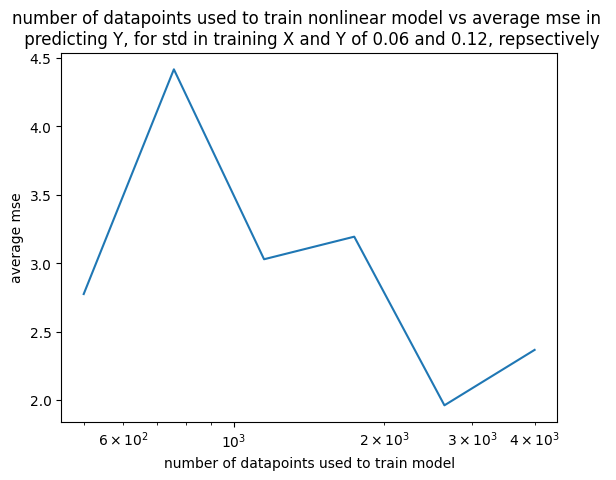

In [111]:
### TASK 3.2: graphs of number of training datapoints against mse for both models

def plot_num_train_datapoints_against_average_mse_for_given_std_in_X_and_Y_linear(nums_of_datapoints_to_test, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y):

    num_datapoints_test = 1000

    # make datapoints to test perfect
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)
    
    list_of_average_mse = []

    for num_datapoints in nums_of_datapoints_to_test:

        print('num_datapoints = ', num_datapoints)

        # create training set with noise and of specificed length
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints, noise_mean_X, noise_std_X=noise_std_X, noise_mean_Y=noise_mean_Y, noise_std_Y=noise_std_Y)

        # train linear model
        C = find_OLS_matrix_with_Action(datapoints_train)


        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to model
            pred_Y = X @ C

            # get mse
            # mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/(num_datapoints_test*16)
        list_of_average_mse.append(average_mse)
    
    # plot graph of number of datapoints used to train against average mse
    print(nums_of_datapoints_to_test, list_of_average_mse)
    plt.plot(nums_of_datapoints_to_test, list_of_average_mse)
    plt.xlabel('number of datapoints used to train model')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('number of datapoints used to train linear model vs average mse in \n predicting Y, for std in training X and Y of {} and {}, repsectively'.format(noise_std_X, noise_std_Y))

    plt.show()


def plot_num_train_datapoints_against_average_mse_for_given_std_in_X_and_Y_nonlinear(nums_of_datapoints_to_test, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y, num_basis_centres, sigma, lamda):

    num_datapoints_test = 1000

    # make datapoints to test perfect
    datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean=0, noise_std=0)
    
    list_of_average_mse = []

    for i, num_datapoints in enumerate(nums_of_datapoints_to_test):

        print('num_datapoints = ', num_datapoints)
        print(i)

        # create training set with noise and of specificed length
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints, noise_mean_X, noise_std_X=noise_std_X, noise_mean_Y=noise_mean_Y, noise_std_Y=noise_std_Y)

        # train nonlinear model on noisy X and Y
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints, noise_mean_X=noise_mean_X, noise_std_X=noise_std_X, noise_mean_Y=noise_mean_Y, noise_std_Y=noise_std_Y)
        alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)


        # test current model on test datapoints
        total_mse = 0
        for datapoint in datapoints_test:
            X = datapoint[0]
            Y = datapoint[1]

            # get predicted Y according to nonlienar model. Action is included as the last entry of X
            new_state = get_next_state_nonlinear(X, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
            pred_Y = new_state - X[:4]
            
            # get mse
            # mse = (pred_Y[0] - real_Y[0])**2 + (pred_Y[1] - real_Y[1])**2 + (pred_Y[2] - real_Y[2])**2 + (pred_Y[3] - real_Y[3])**2
            mse = (pred_Y[0] - Y[0])**2 + (pred_Y[1] - Y[1])**2 + (pred_Y[2] - Y[2])**2 + (pred_Y[3] - Y[3])**2
            total_mse += mse
        
        average_mse = total_mse/(num_datapoints_test*25)
        list_of_average_mse.append(average_mse)
    
    # plot graph of number of datapoints used to train against average mse
    print(nums_of_datapoints_to_test, list_of_average_mse)
    plt.plot(nums_of_datapoints_to_test, list_of_average_mse)
    plt.xlabel('number of datapoints used to train model')
    plt.xscale('log')
    plt.ylabel('average mse')
    plt.title('number of datapoints used to train nonlinear model vs average mse in \n predicting Y, for std in training X and Y of {} and {}, repsectively'.format(noise_std_X, noise_std_Y))

    plt.show()


nums_of_datapoints_to_test = np.logspace(np.log10(100), np.log10(1000), 6)
noise_mean_X = 0
noise_std_X = 0.06
noise_mean_Y = 0
noise_std_Y = 0.12
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
num_basis_centres = 250
#plot_num_train_datapoints_against_average_mse_for_given_std_in_X_and_Y_linear(nums_of_datapoints_to_test, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y)
nums_of_datapoints_to_test = np.logspace(np.log10(500), np.log10(4000), 6)
plot_num_train_datapoints_against_average_mse_for_given_std_in_X_and_Y_nonlinear(nums_of_datapoints_to_test, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y, num_basis_centres, sigma, lamda)


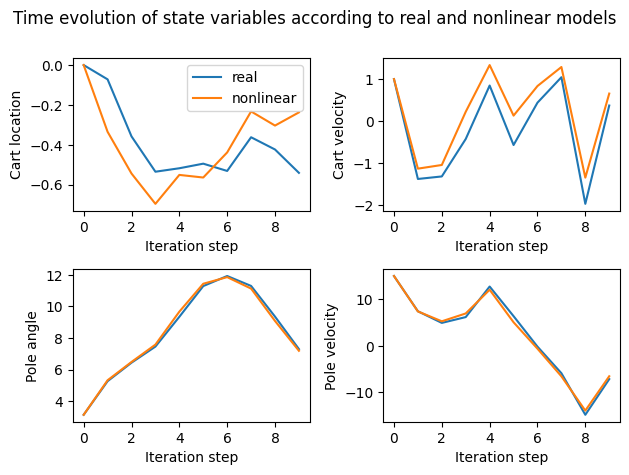

In [115]:

def plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_steps, num_basis_centres, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions=None):

    # initialsie instance of cartpole
    pendulum = CartPole()

    # initialise list of iteration steps
    iteration_steps = list(range(no_steps))

    # initialise empty list into which real states, predicted states will go
    pred_cart_locations = [initial_state[0]]
    pred_cart_velocities = [initial_state[1]]
    pred_pole_angles = [initial_state[2]]
    pred_pole_velocities = [initial_state[3]]
    real_cart_locations = [initial_state[0]]
    real_cart_velocities = [initial_state[1]]
    real_pole_angles = [initial_state[2]]
    real_pole_velocities = [initial_state[3]]

    linear_cart_locations = [initial_state[0]]
    linear_cart_velocities = [initial_state[1]]
    linear_pole_angles = [initial_state[2]]
    linear_pole_velocities = [initial_state[3]]

    actual_state = initial_state
    pred_state = initial_state
    linear_state = initial_state

    # if no actions inputted, same as saying they are all 0
    if list_of_actions is None:
        list_of_actions = np.zeros(no_steps)

    # loop over iteration steps
    for it in iteration_steps:

        # looking for the next state
        it += 1
        if it >= no_steps:
            break
  
        # get next actual state
        pendulum.setState(actual_state[:4])
        pendulum.performAction(actual_state[4])
        next_actual_state = pendulum.getState()
        next_actual_state = np.append(next_actual_state, list_of_actions[it])


        # get next predicted state
        # pred_state has dimension 5, C has dimension 5x5
        pred_change_in_state = find_Y_given_X_according_to_nonlinear_model(pred_state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        next_pred_state = add_lists(pred_state[:4], pred_change_in_state)
        next_pred_state.append(list_of_actions[it])

        # get next linear state
        linear_state_with_action = np.append(linear_state[:4], list_of_actions[it])
        linear_change_in_state = linear_state_with_action @ C # linear_change_in_state has dimension 4
        next_linear_state = linear_state[:4] + linear_change_in_state

        # append states to lists
        pred_cart_locations.append(next_pred_state[0])
        pred_cart_velocities.append(next_pred_state[1])
        pred_pole_angles.append(next_pred_state[2])
        pred_pole_velocities.append(next_pred_state[3])
        real_cart_locations.append(next_actual_state[0])
        real_cart_velocities.append(next_actual_state[1])
        real_pole_angles.append(next_actual_state[2])
        real_pole_velocities.append(next_actual_state[3])
        linear_cart_locations.append(next_linear_state[0])
        linear_cart_velocities.append(next_linear_state[1])
        linear_pole_angles.append(next_linear_state[2])
        linear_pole_velocities.append(next_linear_state[3])
        
        # update current state ready for next iteration
        actual_state = next_actual_state
        pred_state = next_pred_state
        linear_state = next_linear_state
    
    # plot the rollouts
    plt.subplot(2, 2, 1)
    plt.plot(iteration_steps, real_cart_locations, label='real')
    plt.plot(iteration_steps, pred_cart_locations, label='nonlinear')
    #plt.plot(iteration_steps, linear_cart_locations, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart location')
    plt.title('\n')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iteration_steps, real_cart_velocities, label='real')
    plt.plot(iteration_steps, pred_cart_velocities, label='nonlinear')
    #plt.plot(iteration_steps, linear_cart_velocities, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart velocity')
    plt.title('\n')
    #plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(iteration_steps, real_pole_angles, label='real')
    plt.plot(iteration_steps, pred_pole_angles, label='nonlinear')
    #plt.plot(iteration_steps, linear_pole_angles, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole angle')
   
    #plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(iteration_steps, real_pole_velocities, label='real')
    plt.plot(iteration_steps, pred_pole_velocities, label='nonlinear')
    #plt.plot(iteration_steps, linear_pole_velocities, label='linear')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole velocity')
  
    #plt.legend()

    #plt.subplots_adjust(top=10)
    #plt.set_size_inches(1, 1)
    plt.tight_layout()
    plt.suptitle('Time evolution of state variables according to real and nonlinear models') # add in if oscillations or rotations
    plt.show()



## create noisy dataset
##### SET THE NUMBER OF DATAPOINTS AND NOISE STD TO APPROPRIATE VALUES #####
num_datapoints = 500
noise_mean_X = 0
noise_std_X = 0.06
noise_mean_Y = 0
noise_std_Y = 0.06

datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints, noise_mean_X, noise_std_X=noise_std_X, noise_mean_Y=noise_mean_Y, noise_std_Y=noise_std_Y)

# train linear model
C = find_OLS_matrix_with_Action(datapoints_train)

# train nonlinear model
num_basis_centres = 250
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)
alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)


initial_state = np.array([-1, 1, np.pi, 15]) # rotations
initial_state = np.array([0, 0, np.pi, 0])
no_its = 10
#plot_state_variables_over_time_linear_nonlinear_real_with_observation_noise(initial_state, no_its, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)

initial_state = np.array([0, 1, np.pi, 15, 0])
list_of_actions = np.ones(no_its)
list_of_actions = np.array([5, 1, 3, -3, 2, 4, 2, -5, 0, 0])
plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_its, num_basis_centres, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions)

In [116]:
## TASK 3.2: OPTIMISE POLICY USING MODEL PREDICTIVE CONTROL

## train nonlinear model, to best of our ability with noise


num_datapoints_train = 500 ###### SET BASED ON REASONABLE NUMBER FOUND IN PREVIOUS PART
num_basis_centres = 250
lamda = 10 **(-3)
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])

noise_std_for_nonlinear_model_for_model_predictive_policy = 0.01 #######
noise_mean_X = 0
noise_std_X = 0.06
noise_mean_Y = 0
noise_std_Y = 0.06

# train nonlinear model on noisy X and Y
datapoints = make_array_of_XY_datapoints_with_action_with_noisy_X_and_Y(num_datapoints_train, noise_mean_X, noise_std_X, noise_mean_Y, noise_std_Y)
alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda) # used within opt. functions

# define function to return total loss using non-linear model. in form for use with scipy
def total_loss_according_to_non_linear_model(p):
    
    state = [0, 0, 0.1, 0]  # initial state
    no_its = 10 # chosen as nonlinear model is mostly accurate up to this point

    # get loss of first iteration
    pendulum = CartPole()
    pendulum.setState(state)
    loss_value = pendulum.loss()

    # running model simulation and calculating total loss
    for it in range(no_its-1): # no_its-1 becuase first iteration already done

        # get action = policy
        action = np.dot(p, state)
        
        # run one iteration of model simulation to get next state
        state_with_action = list(state)
        state_with_action.append(action)
        Y = find_Y_given_X_according_to_nonlinear_model(state_with_action, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        new_state = np.array(Y) + np.array(state)

        # get and add loss
        pendulum.setState(new_state)
        loss_value += pendulum.loss()

        # set variable state for next iteration
        state = new_state
    
    return loss_value

# trying a variery of initial guesses
def get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses):

    # try a good variety of initial guesses
    array_of_initial_guesses = sobol_seq.i4_sobol_generate(4, num_initial_guesses-1) # had dimensions num_initial_guesses x 4
    array_of_initial_guesses = np.append(array_of_initial_guesses, np.array([[0.357, 0.967, 15.9, 2.39]]), axis=0) # # use optimum found in previous part as the initial guesses

    # shift sequences so that they are scaled and centre 0
    array_of_initial_guesses *= 14
    array_of_initial_guesses -= 14/2

    # initialise list of trials of optimal p
    list_of_potential_ps_and_values = []
    list_of_potential_ps = []
    list_of_potential_values = []

    for initial_guess in array_of_initial_guesses:

        result = minimize(total_loss_according_to_non_linear_model, initial_guess, method='Nelder-Mead', tol=0.01)
        maybe_optimal_p = result.x
        value_at_this_p = result.fun

        print("current initial guess is", initial_guess)

        list_of_potential_ps.append(maybe_optimal_p)
        list_of_potential_values.append(value_at_this_p)
        

        list_of_potential_ps_and_values.append((maybe_optimal_p, value_at_this_p))
    
    # get p that corresponds to minimum value of the function
    min_index = list_of_potential_values.index(min(list_of_potential_values))
    optimal_p = list_of_potential_ps[min_index]

    return optimal_p   

# function to plot time evolution of variables under policy. uses real dynamics, but with noise added to actual state AND obersevations
def plot_time_evolution_of_state_variables_using_real_dynamics_under_policy_with_state_and_observation_noise(initial_state, optimal_p_noisy_XY_model_predictive_control, no_its, noise_std_X, noise_std_Y):

    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    state = initial_state

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [], [], [], []

    # create list for x axis
    iteration_list = list(range(no_its))

    # run no_its simulations
    for it in range(no_its):

        # add noise to actual state itself
        current_state = pendulum.getState()
        oberservation_noise = np.random.normal(0, noise_std_X, 4)
        current_state += oberservation_noise
        pendulum.setState(current_state)
        
        # run one simulation, adding noise to observed dynamics for control
        oberservation_noise = np.random.normal(0, noise_std_Y, 4)
        policy = np.dot(optimal_p_noisy_XY_model_predictive_control, current_state + oberservation_noise)
        pendulum.performAction(policy)
        next_state = pendulum.getState()

        # append state variables to lists to plot
        xs.append(next_state[0])
        xdots.append(next_state[1])
        thetas.append(next_state[2])
        thetadots.append(next_state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('Time evolution of state variables under policy with noise added to state and observations')
    plt.tight_layout()
    plt.show()



## set parameters of nonlinear model in optimizing function for scipy
optimal_p_noisy_X_and_Y_model_predictive_control = get_optimal_p_using_nonlinear_model_trying_various_initial_guesses(num_initial_guesses=5)

print("optimal p found using nonlinear model with noisy X and Y", optimal_p_noisy_X_and_Y_model_predictive_control)


current initial guess is [0. 0. 0. 0.]
current initial guess is [ 3.5 -3.5  3.5 -3.5]
current initial guess is [-3.5  3.5 -3.5  3.5]
current initial guess is [-1.75 -1.75  1.75 -5.25]
current initial guess is [ -2.002   6.538 215.6    26.46 ]
optimal p found using nonlinear model with noisy X and Y [ 0.10135027  1.90441152 14.98566515  2.96875149]


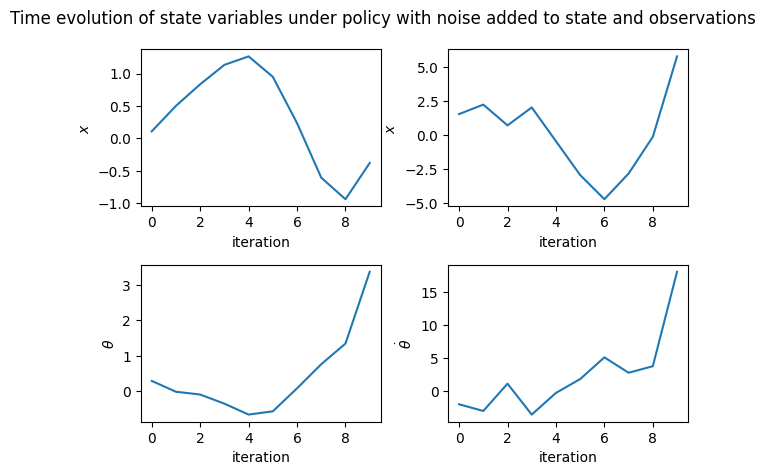

In [135]:

initial_state = np.array([0, 0, 0.5, 0])
no_its = 10
noise_std_X = 0.06
noise_std_Y = 0.06

plot_time_evolution_of_state_variables_using_real_dynamics_under_policy_with_state_and_observation_noise(initial_state, optimal_p_noisy_X_and_Y_model_predictive_control, no_its, noise_std_X, noise_std_Y)

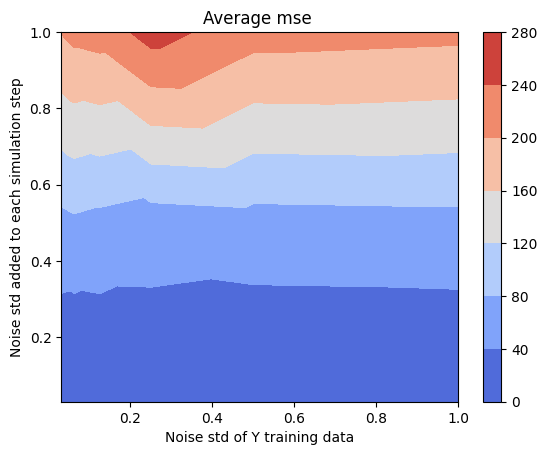

In [ ]:
### LINEAR MODEL ###




# function to plot 2D graph of train noise std and test noise std against mse
# std_train_range, std_test_range need to be numpy arrays of the same length
def plot_contour_plot_of_train_and_test_std_against_mse_linear(std_train_range, std_sim_range, num_its=5):


    x_grid, y_grid = np.meshgrid(std_train_range, std_sim_range)

    # Compute the z values by iterating over all combinations of x and y
    z = []
    for i, (xi, yi) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):


        ## get training datapoints
        num_datapoints_train = 1000 # use 10000
        noise_mean_train = 0
        noise_std_train = xi # is the standard deviation of the noise, if the variable itself was between -1 and 1
        datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean_train, noise_std_train)

        # train model
        C = find_OLS_matrix_with_Action(datapoints_train)

        ## get testing datapoints
        num_datapoints_test = 300
        noise_mean_test = 0
        noise_std_sim = yi # is the standard deviation of the noise, if the variable itself was between -1 and 1

        datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean_test, noise_std_sim)


        ## test models
        model_type = 'linear'
        mse_vector = get_mse_between_actual_and_predicted_states(datapoints_test, C, alpha_x=None, alpha_xdot=None, alpha_theta=None, alpha_thetadot=None, num_basis_centres=None, sigma=None, num_its=num_its, model_type=model_type, noise_var_per_sim=noise_std_sim)
        zi = np.average(mse_vector)

        z.append(zi)
    
    z = np.array(z)
    triangulation = tri.Triangulation(x_grid.flatten(), y_grid.flatten())

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the tricontourf plot
    contour = ax.tricontourf(triangulation, z, cmap='coolwarm')

    # Add a colorbar
    cbar = plt.colorbar(contour)

    # Set axis labels and title
    ax.set_xlabel('Noise std of Y training data')
    ax.set_ylabel('Noise std added to each simulation step')
    ax.set_title('Average mse ')

    # Show the plot
    plt.show()
    
std_train_range = np.logspace(start=-5, stop=0, num=6, base=2)
std_sim_range = np.logspace(start=-5, stop=0, num=6, base=2)
plot_contour_plot_of_train_and_test_std_against_mse_linear(std_train_range, std_sim_range, num_its=2)

In [ ]:
### optimize linear policy ###

In [ ]:


## get training datapoints
num_datapoints_train = 500
noise_mean_train = 0
noise_std_train = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1
datapoints_train = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_train, noise_mean_train, noise_std_train)


# train model
# choose the best parameters from before
num_basis_centres = 100
sigma = [1, 1, 1, 1, 1]
lamda = 0.1

alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints_train, num_basis_centres, sigma, lamda)

## get testing datapoints
num_datapoints_test = 500
noise_mean_test = 0
noise_std_test = 0. # is the standard deviation of the noise, if the variable itself was between -1 and 1

datapoints_test = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints_test, noise_mean_test, noise_std_test)


## test models
num_its = 1

model_type = 'nonlinear'
mse_vector_nonlinear = get_mse_between_actual_and_predicted_states(datapoints_test, C, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma, num_its, model_type)

print('mse_vector_nonlinear = ', mse_vector_nonlinear)

mse_vector_nonlinear =  [ 616.59409946  814.26215276 1301.20488327 9936.60012473]
